In [19]:

import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from typing import List

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Tokenization

### 简介
Tokenization 的主要目的是将文本分解成更小的单位(Tokens)，减小模型输入数据的内在结构复杂度(从句子变为单词序列)，从而简化模型训练的难度。同时将字符的序列转化为Token序号的序列，便于模型输入。

Tokenization 首先确定语言的词表划分粒度，一般可分为：
* 字符级：将文本分解为字符。
* 单词级：将文本分解为单词。
* 子词级：将单词进一步分解为更小的有意义单元（如前缀、后缀）。

之后使用预定义的规则来识别 tokens, 或使用统计或机器学习技术来识别最优的 token 切分方式。例如，BPE（Byte Pair Encoding）或 SentencePiece。

最后实现一组文本序列和Tokens序列之间相互转化的函数，即可完成Tokenization部分。

### 实验要求

1. 实现字符级切分的简单tokenizer， 由 字符表， 字符到token的 encoder()函数 和 token到字符的 decoder() 函数组成。
2. 调用 现有的tokenizer实现，比如openai 的tiktoken

In [20]:
class Tokenizer:
    def __init__(
        self,
        dataPath: str
    ):
        with open(dataPath, "r", encoding="utf-8") as f:
            self.dataset = f.read()
        self.generate_vocabulary()

    def generate_vocabulary(
        self,
    ):
        self.char2index = {}
        self.index2char = {}
        chars = sorted(list(set(self.dataset)))
        pad_char = "#"
        chars = [pad_char] + chars
        self.char2index = {char: idx for idx, char in enumerate(chars)}
        self.index2char = {idx: char for idx, char in enumerate(chars)}

    def encode(
        self,
        sentence: str,
    ) -> torch.Tensor:
        return torch.tensor([self.char2index[char] for char in sentence], dtype=torch.long)

    def decode(
        self,
        tokens: torch.Tensor,
    ) -> str:
        return "".join([self.index2char[idx] for idx in tokens])

### 定义 dataloader 和 dataset

为了高效加载数据，我们需要把输入文件接入 PyTorch 的数据加载器中。在这里我们定义 `ShakespeareDataset` 类用于加载数据集，用 PyTorch 的 `DataLoader` 类来实现数据加载。


In [21]:
class ShakespeareDataset(Dataset):
    def __init__(self, filepath, tokenizer, chunk_size):
        self.tokenizer = tokenizer
        with open(filepath, 'r', encoding='utf-8') as file:
            text = file.read()
        self.encoded = self.tokenizer.encode(text)
        self.chunk_size = chunk_size

    def __len__(self):
        return len(self.encoded) - self.chunk_size

    def __getitem__(self, idx):
        #TODO: 提取一段文本(长度为 chunk_size）作为输入，以及这段文本的每一个字符的下一个字符作为标签
        # example(not correspond to real text): chunk = tensor([ 0, 20, 49, 58, 59])
        #         label = tensor([20, 49, 58, 59, 19])
        # decoded chunk: "The "
        # decoded label: "he T"
        chunk = self.encoded[idx:idx+self.chunk_size]
        label = self.encoded[idx+1:idx+self.chunk_size+1]
        return chunk, label

tokenizer = Tokenizer(dataPath="input.txt")

def create_dataloader(filepath, tokenizer, chunk_size, batch_size, shuffle=True):
    dataset = ShakespeareDataset(filepath, tokenizer, chunk_size)
    train_dataset,val_dataset = torch.utils.data.random_split(dataset,[int(len(dataset)*0.8),len(dataset)-int(len(dataset)*0.8)])
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle)
    val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=shuffle)
    return train_dataloader, val_dataloader


train_dataloader,val_dataloader = create_dataloader('input.txt', tokenizer, chunk_size=200, batch_size=2)



注意力的计算公式为：
$$
Head = Attention(x)=Softmax(M\cdot QK^T)V\\
Q=xW_{q},K=xW_{k}, V=xW_{v}
$$
这里实现的一些数学技巧可以参见attention.ipynb

In [22]:
class HeadAttention(nn.Module):
    def __init__(self, seq_len: int, embed_size: int, hidden_size: int,
                 bias: bool = True, dropout_prob: float = 0.1):
        super().__init__()
        # embed_size: dimension for input embedding vector
        # hidden_size: dimension for hidden vector. eg. x:(..., embed_size) --to_q--> query_vector:(..., hidden_size)

        # a triangular bool matrix for mask
        self.register_buffer("tril", torch.tril(
            torch.ones(seq_len, seq_len)))  # mask

        # TODO: init three matrix, to_q, to_k, to_v.
        self.to_q = nn.Linear(embed_size, hidden_size, bias=bias)
        self.to_k = nn.Linear(embed_size, hidden_size, bias=bias)
        self.to_v = nn.Linear(embed_size, hidden_size, bias=True)
        self.dropout = nn.Dropout(dropout_prob)

    def forward(self, inputs):
        # input: (batch_size, seq_len, embed_size)
        # return (batch_size, seq_len, hidden_size), attention:(seq_len, seq_len)
        # TODO: implement the attention mechanism
        q = self.to_q(inputs)
        k = self.to_k(inputs)
        v = self.to_v(inputs)
        scale = 1 / torch.sqrt(torch.tensor(k.size(-1), dtype=torch.float32))
        # (batch_size, seq_len, seq_len)
        attention = torch.matmul(q, k.transpose(-2, -1))*scale

        attention = attention.masked_fill(self.tril == 0, float('-inf'))
        attention = F.softmax(attention, dim=-1)

        attention = self.dropout(attention)
        out = attention@v
        return out, attention[-1]

Transformer中使用的注意力机制时会使用多个注意力头，期望每个注意力头能够注意到不同的信息。
所以实际公式需要修改如下
$$
MultiHeadAttention(x)=[Head_0, Head_1,...,Head_h]W_o\\
Head_i = Attention(x)=Softmax(M\cdot Q_iK_i^T)V_i\\
Q_i=xW_{iq},K=xW_{ik}, V=xW_{iv}
$$
在搭建网络的过程中，同学们可能会用到nn.ModuleList这个库，每个$Head_i$的计算可以直接使用上面已经实现的单头注意力计算。
最后对于这些注意力头再使用一个简单的线性层/矩阵$W_o$汇总信息即可

In [23]:
class MultiHeadAttention(nn.Module):
    def __init__(self, n_heads: int, head_size: int, seq_len: int, embed_size: int):
        # n_heads is the number of head attention
        # head_size is the hidden_size in each HeadAttention
        super().__init__()
        head_size = embed_size // n_heads

        self.n_heads = n_heads
        self.head_size = head_size
        self.heads = nn.ModuleList(
            [HeadAttention(seq_len, embed_size, head_size) for _ in range(n_heads)])
        self.projection = nn.Linear(n_heads*head_size, embed_size)

    def forward(self, inputs):
        # input: (batch_size, seq_len, embed_size), make sure embed_size=n_heads x head_size
        # return: (batch_size, seq_len, embed_size), attn: (seq_len, seq_len)
        assert inputs.size(-1) == self.n_heads * self.head_size

        heads_out = [head(inputs)[0] for head in self.heads]
        # attn取最后一个head
        attn = self.heads[-1](inputs)[1]
        out = torch.cat(heads_out, dim=-1)
        out = self.projection(out)
        return out, attn

## 专家网络 Expert

Expert即为标准Transformer中的FeedForward模块。

在经过MultiHeadAttention 模块后，seq_len中的每一个Embedding都对应了前文信息的加权求和。在经过FeedForward模块时，模型对每一个位置的Embedding进行了两次线性变换和一次非线性变换，可以视为对当前语境下的信息进行加工。知识编辑的一些研究表明，FeedForword 模块参数包含了大量的事实性知识。

一个直观的想法是，类比于MultiHeadAttention，我们在每一层训练多个FeedForward模块，对于不同位置的Embedding使用不同的FeedForward模块处理对应的信息。就好像每层有多个Expert,每个Expert都负责处理一类数据的深加工，因此我们称FeedForward为Expert。

实现方面:

FeedForward层由两层简单的线性层组成，对于一个(batch_size, seq_len, embed_size)输入的向量x
只在最后一个维度上进行计算，以实现词的特征维度上的交互(注意力机制是词之间的交互)。
其首先用一个线性层将x最后一维扩大至原先4倍，然后继续用一个线性层还原回原先的维度。

In [24]:
class Expert(nn.Module):
    '''
    FFN module, which is a two-layer feed-forward network with activation function.
    '''
    def __init__(self, embed_size: int, dropout_prob: float = 0.1):
        super().__init__()

        self.layer1 = nn.Linear(embed_size, 4*embed_size)
        self.layer2 = nn.Linear(4*embed_size, embed_size)
        self.activation = nn.GELU()  # GELU  or ReLU
        self.dropout = nn.Dropout(dropout_prob)

    def forward(self, inputs):
        # inputs: (batch_size, seq_len, embed_size)
        # -> mid: (batch_size, seq_len, 4 x embed_size)
        # -> outputs: (batch_size, seq_len, embed_size)
        mid = self.layer1(inputs)
        mid = self.activation(mid)
        mid = self.dropout(mid)
        out = self.layer2(mid)
        return out
        

## 选通网络 TopkRouter

在实现了单个Expert后，我们要设计一个选通网络决策每个Embedding要使用那个Expert计算


### 为了说明选通网络的实现方式，我们定义一下记号：

inputs.shape = [batch_size, seq_len, embed_size] = [1, 8, 16] 

即输入有batch_size=1个数据点，该数据有seq_len长度的context，即包含seq_len=8个Embedding，每个Embedding长度为embed_dim=16。

记 num_expert = 4, 即该层包含 num_expert 个并列的Expert。

记 active_expert = 2, 即计算每个Embedding仅有 active_expert 个Expert 参与计算。

### 选通网络计算
对于有seq_len=8的数据，如果每个Expert都参与计算每一个Embedding，那么一共需要计算 seq_len*num_expert = 32 次， 这极大的增加了模型计算量，因此我们往往只激活其中的active_experts个Expert，这要求我们对每一个Embedding计算最合适的active_experts个 Expert。

对于单个Expert 的原版Transformer来说：

$$
outputs[0,seq] = FeedForward(inputs[0,seq])
$$

对于多个Expert的网络：

$$
outputs[0,seq] = \sum_{i \in range(num\_model)} \alpha_{i} Expert_{i}(inputs[0,seq])
$$

$$
\alpha_{i} = \left\{
\begin{array}{ll}
    1 & Expert_{i}  \text{is selected} \\
    0 & Expert_{i}  \text{is not selected} \\
\end{array}
\right.
$$
将$\{\alpha_0,\alpha_1,\dots,\alpha_{num_experts-1}\}$记为向量$\alpha$:
$$
outputs[0,seq] = \alpha \cdot \{Expert_i(inputs[0,seq])\}
$$

一个选通0,2号Expert的$\alpha$的例子是$[1,0,1,0]$

问题在于如何求得 $\alpha$, 对于一个Embedding ，我们使用神经网络对每个Expert打分，在根据分数计算$\alpha$

$$
score[0,seq] = MLP(inputs[0,seq])  \\
\alpha = topK(score[0,seq])
$$

例如：

$$
score[0,seq] = [11.32,1.54,14.83,-1.90] \\
\alpha = [1,0,1,0]
$$

从优化的角度来说，$\alpha$取前k大的分数的下标（即argmax），这个操作是不可导的，这里我们用之前在"attention.ipynb"中提到的技巧处理这里的计算。

$$
mask(score[0,seq]) = [11.32,-inf,14.83,-inf] \\
\alpha = softmax(mask(score[0,seq])) = [0.028,0,0.971,0] \\
index = [1,0,1,0]
$$

我们用这个$\alpha$和$index$用做选通网络.

In [25]:
class TopkRouter(nn.Module):
    def __init__(self, embed_size: int, num_experts: int, active_experts: int):
        ''' 
        TODO
        @embed_size : dimension of embedding 
        @num_experts : how many Experts per layer
        @active_experts: only active_experts out of num_experts are selected to process Embeddings per token.
        '''
        super().__init__()
        self.num_experts = num_experts
        self.active_experts = active_experts
        self.score_layer = nn.Linear(embed_size, num_experts)

    def get_scores(self, inputs):
        """
        socre[0:seq] = MLP(inputs[0:seq])
        @input  inputs: (batch_size, seq_len, embed_size)
        @return scores: (batch_size, seq_len, num_experts)
        """
        out = self.score_layer(inputs)
        out = F.softmax(out, dim=-1)
        return out

    def forward(self, inputs):
        ''' TODO
        完成这部分时，注意使用Softmax()对router_output做标准化。同时注意这部分所用操作的可导性。
        inputs is the output tensor from multihead self attention block, shape (B:batch size, T: seq_len, C: embed_size)
        return:
        --- 
        router_output: normalized weight of Experts, 即教程中的 \alpha
        indices:   index of selected Experts, 即教程中的 index
        '''
        scores = self.get_scores(inputs)
        # mask,只保留active_experts个最大值
        topk_value, top_k_indices = scores.topk(self.active_experts, dim=-1)
        mask = torch.zeros_like(scores).scatter_(
            dim=-1, index=top_k_indices, value=1.0)
        indices = mask
        masked_scores = scores * mask

        masked_scores = masked_scores.masked_fill(mask == 0, float('-inf'))
        router_output = F.softmax(masked_scores, dim=-1)
        return router_output, indices
    

## 稀疏专家网络 SparseMoE

![moe](./moeSparse.png)

在定义完Expert 和 TopkRouter后，我们可以定义SparseMoE模块。

在前向过程中，对于inputs.shape = [Batch_size,seq_len,embed_size]第二维度seq_len个Embedding,我们先利用TopkRouter计算出选通专家序号indices以及专家权重router_output。

我们将Embedding通过选通的Expert得出active_expert个新的Embedding，然后使用router_output的作为权重对新的Embedding加权求和作为输出。


In [26]:
class SparseMoE(nn.Module):
    def __init__(self, embed_size: int, num_experts: int, active_experts: int):
        super().__init__()
        self.router = TopkRouter(embed_size, num_experts, active_experts)
        self.experts = nn.ModuleList(
            [Expert(embed_size) for _ in range(num_experts)])

    def forward(self, inputs):
        # TODO
        # 1. get router_output  from router
        # (batch_size, seq_len, num_experts)
        experts_weights, _ = self.router(inputs)
        # 2. get expert_output from experts
        # [num_experts, (batch_size, seq_len, embed_size)]
        expert_outputs = [expert(inputs) for expert in self.experts]
        # 3. merge expert_output with router_output
        # (batch_size, seq_len, embed_size, num_experts)
        expert_outputs = torch.stack(expert_outputs, dim=-1)
        if torch.isnan(expert_outputs).any():
            expert_outputs[
                torch.isnan(expert_outputs)
            ] = 0
        # Combine expert outputs and gating scores
        moe_output = torch.sum(
            experts_weights.unsqueeze(-2) * expert_outputs, dim=-1
        )
        # 4. return the final output
        # (batch_size, seq_len, embed_size)
        return moe_output


Transformer由一层层的block堆叠而成，其中每个block的结构从模型的结构图展开中可以看到，由LayerNorm，Masked multi head attention，(SparseMoE)FeedForward组成。

对于一个表示句子的输入向量x，其首先会经过Layer Normalization层.
Layer Normalization 层对于一个 句子个数x句子长度x单词向量维度 的输入 x, 会在最后两维上进行规范化处理，起到稳定训练的作用。

$$
LN(x)=\frac{x-mean(x)}{\sqrt{var(x)+\epsilon}}\cdot\gamma+\beta
$$

其中mean和var都是在最后两个维度上进行的，layernorm的实现同学们可以直接调用nn.LayerNorm
经过layernorm层后，再经过Mask multi head attention层之后，会在+号处再次和原始的输入进行相加，这样的做法能够提高训练的稳定性。有兴趣的同学可以从梯度角度思考原因，或者搜索残差连接相关资料进行学习。
之后再同样经过一层layernorm和feedforwad之后，就可以得到block块的输出了。
即 x' = x+MHA(LN(x)), y = FFN(LN(x'))+x'

In [27]:
class Block(nn.Module):
    # Transformer basic block, consist of MultiHeadAttention, FeedForward and layer normalization
    def __init__(self, embed_size: int, n_heads: int, seq_len: int, num_experts: int, active_experts: int):
        super().__init__()
        # TODO: implement block structure
        super().__init__()
        self.attn = MultiHeadAttention(
            n_heads, embed_size, seq_len, embed_size)
        self.layer_norm = nn.LayerNorm(embed_size)
        self.moe = SparseMoE(embed_size, num_experts, active_experts)

    def forward(self, inputs):
        # input: (batch_size, seq_len, embed_size)
        # TODO: forward with residual connection
        resi = inputs
        x, attn = self.attn(inputs)
        x = x + resi  # add residual connection
        x = self.layer_norm(x)
        add_normed = x

        ##### MoE #####
        x = self.moe(x)
        x = x + add_normed
        x = self.layer_norm(x)
        return x, attn


In [28]:
# Pos
def get_positional_encoding(d_model: int, seq_len: int = 5000):
    '''
    @param d_model: int: number of features in the query, key, and value vectors
    @param seq_len: int: maximum length of the input sequence
    @return encodings: torch.Tensor: positional encodings of shape (seq_len, d_model)
    '''
    encodings = torch.zeros(seq_len, d_model)
    position = torch.arange(0, seq_len, dtype=torch.float32).unsqueeze(1)
    two_i = torch.arange(0, d_model, 2, dtype=torch.float32)
    div_term = torch.exp(two_i*(-math.log(10000.0)/d_model))
    encodings[:, 0::2] = torch.sin(position*div_term)
    encodings[:, 1::2] = torch.cos(position*div_term)
    encodings = encodings.unsqueeze(0).requires_grad_(False)
    return encodings


class AddPositionEncoding(nn.Module):
    def __init__(self, d_model: int, seq_len: int, dropout_prob: float = 0.1):
        """
        d_model: number of features in the query, key, and value vectors
        seq_len: maximum length of the input sequence
        """
        super().__init__()
        self.dropout = nn.Dropout(dropout_prob)
        self.register_buffer('positional_encoding',
                             get_positional_encoding(d_model, seq_len), False)

    def forward(self, x: torch.Tensor):
        pe = self.positional_encoding.detach().requires_grad_(False)
        x = x + pe
        x = self.dropout(x)
        return x


In [29]:
class SparseMoETransformer(nn.Module):
    ''' 
    Transformer decoder, consist of 
    token embedding layer and position_embedding(position_embedding 可以理解为对位置编码，感兴趣的同学可以查阅原文，这里可以看为vocab_len = seq_len的Embedding)
    a stack of Transformer basic block
    a layernorm and output linear layer
    '''

    def __init__(self,
                 vocab_size: int, seq_len: int,
                 embed_size: int,
                 n_layers: int,
                 n_heads: int,
                 num_experts: int, active_experts: int,
                 verbose: bool = False):
        # vocab_size is the number of word in vocabulary dict
        # seq_len is the sequence length/sentence length
        # embed_size is the embedding vector dimension
        super().__init__()
        # TODO:
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.positional_encoding = AddPositionEncoding(embed_size, seq_len)
        self.blocks = nn.ModuleList([Block(embed_size, n_heads=n_heads, seq_len=seq_len,
                                    num_experts=num_experts, active_experts=active_experts) for _ in range(n_layers)])
        self.attention_list = []
        self.to_out = nn.Sequential(
            nn.Softmax(dim=-1),
            nn.LayerNorm(embed_size),
            nn.Linear(embed_size, vocab_size),
        )
        self.seq_len = seq_len
        self.norm = nn.LayerNorm(embed_size)

    def forward(self, inputs, labels=None):
        # labels: the (ground) true output
        # TODO: implement the forward function of the transformer

        # inputs:(batch_size, seq_len, )
        batch_size, seq_len, = inputs.shape
        # embedding:(batch_size, seq_len, embed_size)
        embedding = self.embedding(inputs)

        # add positional encoding
        pe_x = self.positional_encoding(embedding)
        x = self.norm(pe_x)

        self.attention_list = []
        # attens:(batch_size, seq_len, embed_size)
        for block in self.blocks:
            x, attn = block(x)
            self.attention_list.append(attn)
        # logits:(batch_size, seq_len, vocab_size)
        logits = self.to_out(x)
        # compute the loss

        if labels is None:
            loss = None
        else:
            batch_size, seq_len, vocab_size = logits.shape
            logits = logits.view(batch_size * seq_len, vocab_size)
            labels = labels.view(batch_size * seq_len)
            loss = F.cross_entropy(logits, labels)
        return logits, loss

    def get_attn_list(self):
        return self.attention_list

    def generate(
        self,
        inputs: str,
        max_new_tokens: int,
        tokenizer: Tokenizer,
        # k: int = 5,

    ) -> str:
        """
        Generate text using a Top-k sampling strategy.

        Args:
            inputs (str): The input text to the model.
            max_new_tokens (int): The maximum number of new tokens to generate.
            tokenizer: Tokenizer): The tokenizer used to encode and decode text.
            k (int): Number of top tokens to consider for sampling (default is 5).

        Returns:s
            str: The generated text.
        """
        inputs = tokenizer.encode(inputs).clone().detach().unsqueeze(0)
        device = next(self.parameters()).device
        inputs = inputs.to(device)
        nul_char = tokenizer.encode('#')[0]
        if inputs.size(1) > self.seq_len:
            inputs = inputs[:, :self.seq_len]
        elif inputs.size(1) < self.seq_len:
            # 左边padding
            inputs = F.pad(inputs, (self.seq_len - inputs.size(1), 0),
                           value=nul_char)
        generated = inputs  # shape: (batch_size=1, seq_len=21)
        for _ in range(max_new_tokens):
            if generated.size(1) > self.seq_len:
                generated_input = generated[:, -self.seq_len:]
            else:
                generated_input = generated
            logits, _ = self.forward(generated_input)
            last_logits = logits[:, -1, :]
            next_token_ids = torch.argmax(last_logits, dim=-1)
            next_token_ids = next_token_ids.unsqueeze(-1)
            generated = torch.cat([generated, next_token_ids], dim=1)
        return generated


# 训练循环

如果你已经完成了模型定义等内容，训练的过程实际上在高度封装的 Pytorch 库中非常简单, 因为你并不需要写对应的反向传播。



#### Loss 

Loss 用来**衡量**模型预测与真实值之间的**差距**。

常见的几个 Loss 函数：

* 交叉熵：$\text{CrossEntropy Loss} = -\sum_{i=1}^{n} y_i \log(\hat{y}_i)$
* 均方误差：$\text{MSE} = \frac{1}{n}\sum_{i=1}^{n}(y_i - \hat{y_i})^2$
* 绝对误差：$\text{MAE} = \frac{1}{n}\sum_{i=1}^{n} |y_i - \hat{y_i}|$

不同的 loss 对应不同的优化目标，如果写错 loss 函数会导致模型不收敛/性能很差。

#### 训练循环

当我们写好 Optimizer 和 Loss 之后，对应的训练循环就十分简单了。

我们只需要做以下事情：

* 从 dataloader 里面拿到一个 batch 的数据以及标签
* 将数据送入模型，进行前向传播
* 拿到模型输出的 logits
* 将 logits 和 标签进行 loss 计算
* 用 Optimizer 
    * 清空梯度
    * 反向传播
    * 更新参数

In [30]:
from tqdm import tqdm

LEARNING_RATE = 1e-3
WEIGHT_DECAY = 5e-4
def train(model, dataloader, epoch, device):
    optimizer =  torch.optim.Adam(
        model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY) 
    model.train()
    total_loss = 0
    for i, (inputs, targets) in tqdm(enumerate(dataloader), total=len(dataloader)):
        # TODO: implement the training process, and compute the training loss and validation loss
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        logits, loss = model(inputs, targets)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    print(f'Epoch {epoch} Loss: {total_loss / len(dataloader)}')
    return total_loss / len(dataloader)

def validate(model, dataloader, epoch, device):
    model.eval()
    # TODO: 实现验证函数。与训练函数类似，但不需要计算梯度。
    total_loss = 0
    for i, (inputs, targets) in tqdm(enumerate(dataloader), total=len(dataloader)):
        inputs, targets = inputs.to(device), targets.to(device)
        logits, loss = model(inputs, targets)
        total_loss += loss.item()
    print(f'Epoch {epoch} Loss: {total_loss / len(dataloader)}')
    return total_loss / len(dataloader)
    

In [31]:

def run(model, train_dataloader, valid_dataloader, device, epochs=10):
    train_loss_list = []
    valid_loss_list = []
    for epoch in range(epochs):
        train_loss = train(model, train_dataloader, epoch, device)
        valid_loss = validate(model, valid_dataloader, epoch, device)
        train_loss_list.append(train_loss)
        valid_loss_list.append(valid_loss)
        print(
            f'Epoch {epoch} Train Loss: {train_loss}, Valid Loss: {valid_loss}')
    return train_loss_list, valid_loss_list


In [32]:
import os
import numpy as np
print(f"device: {device}")
BATCH_SIZE = 128
EPOCHS = 10
token_path = 'input.txt'
tokenizer = Tokenizer(dataPath=token_path)
SEQ_LEN = 256
train_oader, val_loader = create_dataloader(
    'input.txt', tokenizer, chunk_size=SEQ_LEN, batch_size=BATCH_SIZE)
model = SparseMoETransformer(vocab_size=len(tokenizer.char2index), seq_len=SEQ_LEN,
                                embed_size=64, n_layers=3, n_heads=8, num_experts=8, active_experts=2).to(device)
# 判断是否有训好的模型
if os.path.exists('./output/model.pth'):
    model.load_state_dict(torch.load('./output/model.pth'))
else:
    print('No model found, training from scratch')
    train_loss_list, valid_loss_list = run(
        model, train_oader, val_loader, device=device, epochs=EPOCHS)
    # 保存模型
    torch.save(model.state_dict(), '/output/model.pth')
    # 存list为np,因为是丢远程跑所以存下来
    np.save('/output/train_loss_list.npy', np.array(train_loss_list))
    np.save('/output/valid_loss_list.npy', np.array(valid_loss_list))
pad_char = '#'
ans = tokenizer.decode(model.generate(
    "I could pick my lance ", max_new_tokens=256, tokenizer=tokenizer)[0].tolist())
print(ans.strip(pad_char))
attn_list = model.get_attn_list()
torch.save(attn_list, './output/attn_list.pth')

device: cuda
I could pick my lance to
The sent of the seat of the stands of the state
The senter of the stand the state to the strands,
And the shall be so stand the senself and sorrows
Than the soul to see to the strain's sometiments
That the stand the seat of the father so sounds,
And the


[1.90808488 1.60245434 1.55447902 1.53201866 1.51780817 1.50727181
 1.49903833 1.4921763  1.48614111 1.48092688 1.47596078 1.4716521
 1.46770837 1.46414538 1.46100765]


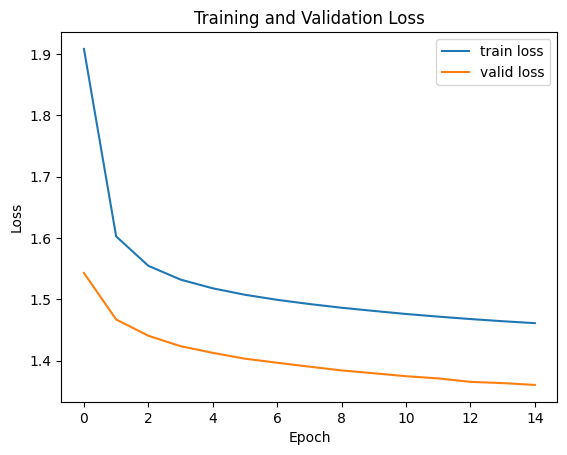

In [33]:
import matplotlib.pyplot as plt
#plot loss
def plot(train_loss_list, valid_loss_list, save_path: str = None):
    plt.figure()
    plt.plot(train_loss_list, label='train loss')
    plt.plot(valid_loss_list, label='valid loss')
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    if save_path is not None:
        plt.savefig(save_path)
    else:
        plt.show()


train_loss_list = np.load('./output/train_loss_list.npy')
valid_loss_list = np.load('./output/valid_loss_list.npy')
print(train_loss_list)
save_path = './output/loss_plot.png'
plot(train_loss_list, valid_loss_list, save_path)

3it [00:00,  6.98it/s]


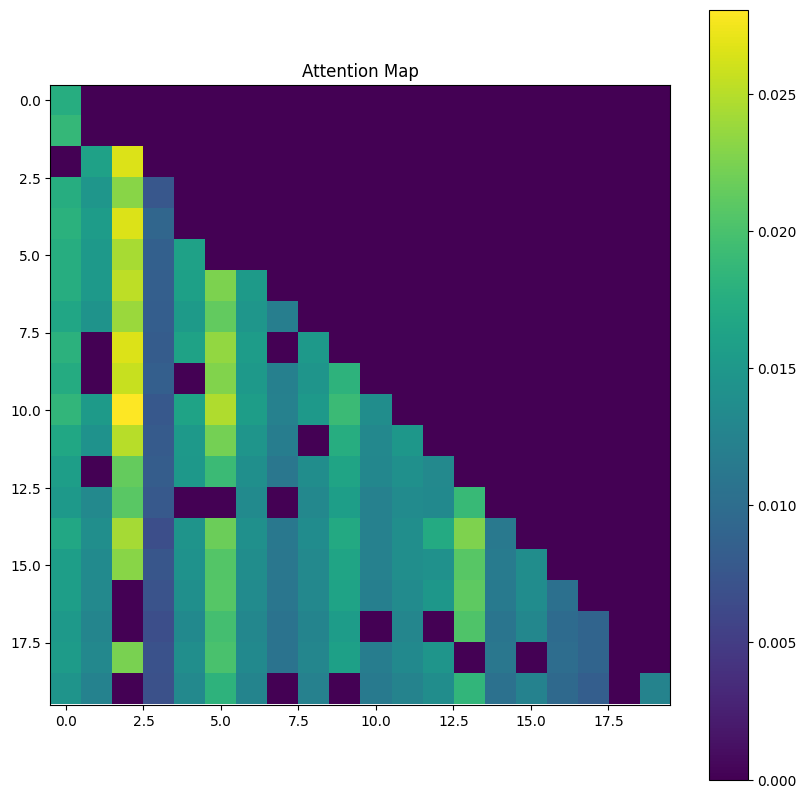

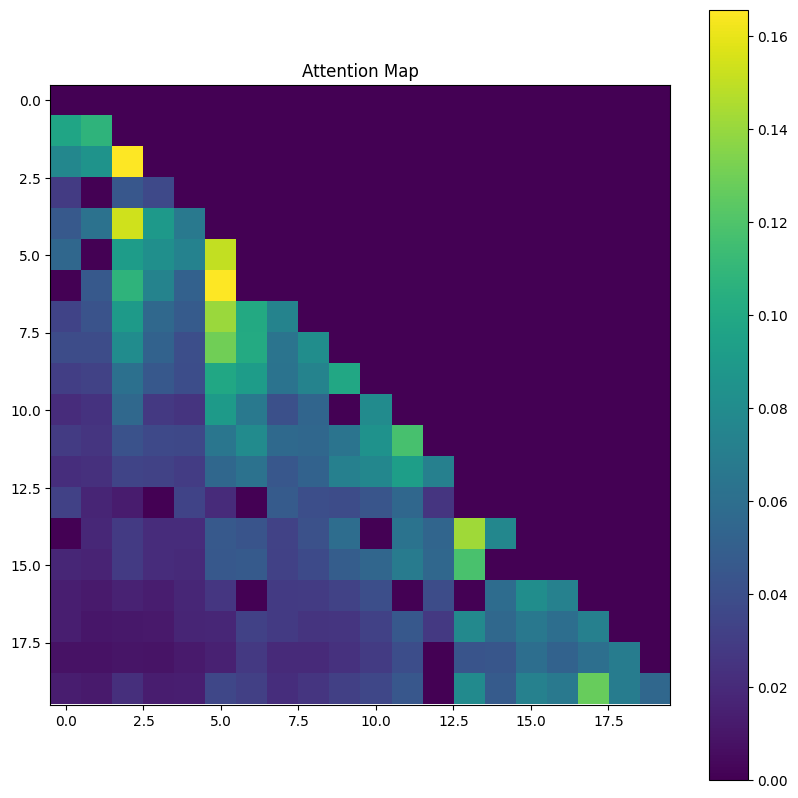

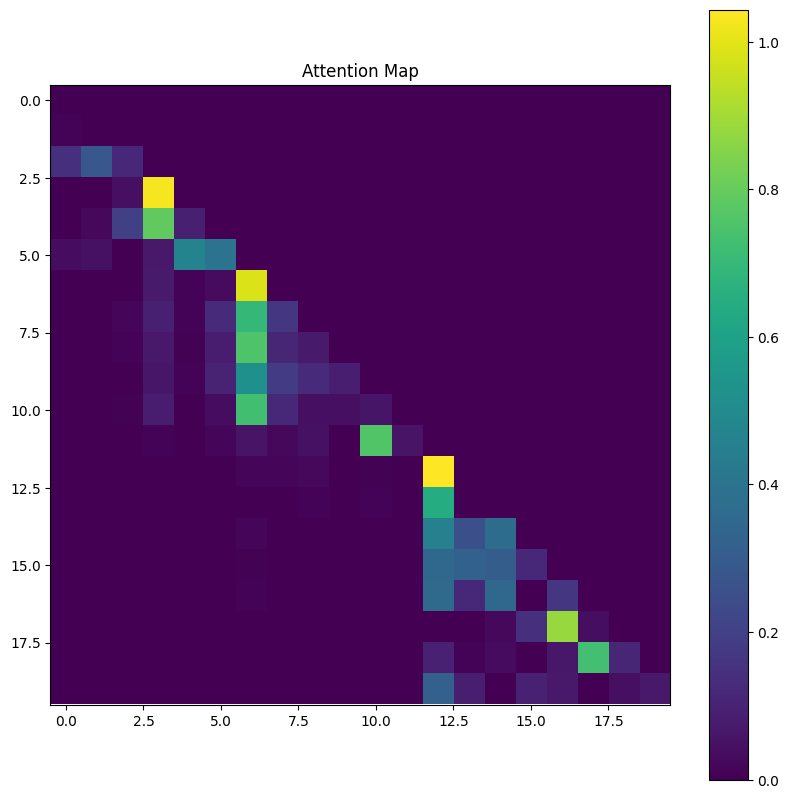

In [35]:
#plot attention
def plot_attention_map(attention_map, save_path: str = None):
    """
    Plot the attention map
    Args:
        attention_map: 2D numpy array
        save_path: str, path to save the plot
    """
    plt.figure(figsize=(10,10))
    plt.imshow(attention_map, cmap='viridis')
    plt.colorbar()
    plt.title('Attention Map')

    if save_path is not None:
        plt.savefig(save_path)
    else:
        plt.show()



if os.path.exists('./output/attn_list.pth'):
    attn_list = torch.load('./output/attn_list.pth')
    # torch to numpy
    attn_list = [attn.cpu().detach().numpy() for attn in attn_list]
    # 取最后 20x20个 grid
    attn_list = [attn[-20:, -20:] for attn in attn_list]
    for i, attn in tqdm(enumerate(attn_list)):
        plot_attention_map(attn, f'./output/img/attention_map_{i}.png')

else:
    raise FileNotFoundError('No attention list found')